In [ ]:
#Imports and gym creation
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import Adam
import random

In [ ]:
#Create Gym
from gym import wrappers
envCartPole = gym.make('CartPole-v1')
envCartPole.seed(50)

[50]

In [ ]:
EPISODES = 500
TRAIN_END = 0

In [ ]:
discount_rate = .95
learning_rate = .001
batch_size = 24

In [ ]:
class DoubleDQNetwork():
    def __init__(self, states, actions, alpha, gamma, epsilon, epsilon_min, epsilon_decay):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=2500)
        self.alpha = alpha
        self.gamma = gamma

        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.model_target = self.build_model() #Second (target) neural network
        self.update_target_from_model() #Update weights
        self.loss = []

    def build_model(self):
        model = keras.Sequential() #linear stack of layers https://keras.io/models/sequential/
        
        #input layer
        model.add(keras.layers.Dense(24, input_dim=self.nS, activation='relu'))
        #   Dense: Densely connected layer https://keras.io/layers/core/
        #   24: Number of neurons
        #   input_dim: Number of input variables
        #   activation: Rectified Linear Unit (relu) ranges >= 0
        
        #2 hidden layers
        model.add(keras.layers.Dense(24, activation='relu')) #Layer 2 -> 3
        model.add(keras.layers.Dense(self.nA, activation='linear')) #Layer 3 -> [output]
        #   Size has to match the output (different actions)
        #   Linear activation on the last layer
        model.compile(loss='mean_squared_error', #Loss function: Mean Squared Error
                      optimizer=keras.optimizers.Adam(lr=self.alpha)) #Optimaizer: Adam
        return model

    def update_target_from_model(self):
        #Update the target model from the base model
        self.model_target.set_weights(self.model.get_weights())

    def action(self, state):
        #Explore
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA) 
        
        #Exploit: use neural network to predict the correct action from this state
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])
    
    def test_action(self, state): #Exploit
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])

    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append((state, action, reward, nstate, done))
    
    def experience_replay(self, batch_size):
        #Execute the experience replay
        #Randomly sample from memory
        minibatch = random.sample( self.memory, batch_size ) 

        #Convert to numpy for speed by vectorization
        x = []
        y = []
        np_array = np.array(minibatch)
        
        #States
        st = np.zeros((0,self.nS))

        #Next States
        nst = np.zeros((0,self.nS))
        
        #Creating the state and next state np arrays
        for i in range(len(np_array)): 
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0)

        st_predict = self.model.predict(st) #Here is the speedup! I can predict on the ENTIRE batch
        nst_predict = self.model.predict(nst)
        nst_predict_target = self.model_target.predict(nst) #Predict from the TARGET
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_target = nst_predict_target[index]
            nst_action_predict_model = nst_predict[index]
            if done == True: #Terminal: Just assign reward much like {* (not done) - QB[state][action]}
                target = reward
            else:   #Non terminal
                target = reward + self.gamma * nst_action_predict_target[np.argmax(nst_action_predict_model)] #Using Q to get T is Double DQN
            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1

        #Reshape for Keras Fit
        x_reshape = np.array(x).reshape(batch_size,self.nS)
        y_reshape = np.array(y)
        epoch_count = 1
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        
        #Graph Losses
        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )
            
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
#Create the agents
nS = envCartPole.observation_space.shape[0] #This is only 4
nA = envCartPole.action_space.n #Actions
dqn = DoubleDQNetwork(nS, nA, learning_rate, discount_rate, 1, 0.001, 0.995 )

batch_size = batch_size

In [ ]:
#Training
rewards = [] #Store rewards for graphing
epsilons = [] # Store the Explore/Exploit
TEST_Episodes = 0

for e in range(EPISODES):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS]) # Resize to store in memory to pass to .predict
    tot_rewards = 0

    for time in range(210): #200 is when you "solve" the game. This can continue forever as far as I know
        action = dqn.action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn.store(state, action, reward, nstate, done) # Resize to store in memory to pass to .predict
        state = nstate
        #done: CartPole fell. 
        #time == 209: CartPole stayed upright
        if done or time == 209:
            rewards.append(tot_rewards)
            epsilons.append(dqn.epsilon)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, dqn.epsilon))
            break

        #Experience Replay
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)
    
    #Update the weights after each episode (You can configure this for x steps as well
    dqn.update_target_from_model()
    #If our current NN passes we are done
    #I am going to use the last 5 runs
    if len(rewards) > 5 and np.average(rewards[-5:]) > 195:
        #Set the rest of the EPISODES for testing
        TEST_Episodes = EPISODES - e
        TRAIN_END = e
        break

episode: 0/500, score: 15.0, e: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


episode: 1/500, score: 21.0, e: 0.946354579813443
episode: 2/500, score: 22.0, e: 0.851801859600347
episode: 3/500, score: 20.0, e: 0.7744209942832988
episode: 4/500, score: 10.0, e: 0.7402609576967045
episode: 5/500, score: 20.0, e: 0.6730128848950395
episode: 6/500, score: 18.0, e: 0.6180388156137953
episode: 7/500, score: 20.0, e: 0.5618938591163328
episode: 8/500, score: 9.0, e: 0.5398075216808175
episode: 9/500, score: 10.0, e: 0.5159963842937159
episode: 10/500, score: 17.0, e: 0.47622912292284103
episode: 11/500, score: 12.0, e: 0.4506816115185697
episode: 12/500, score: 14.0, e: 0.4222502236424958
episode: 13/500, score: 13.0, e: 0.3976004408064698
episode: 14/500, score: 11.0, e: 0.37816180712868996
episode: 15/500, score: 9.0, e: 0.3632974174544486
episode: 16/500, score: 11.0, e: 0.3455358541129786
episode: 17/500, score: 11.0, e: 0.32864265128599696
episode: 18/500, score: 9.0, e: 0.3157247089126454
episode: 19/500, score: 9.0, e: 0.3033145315372582
episode: 20/500, score: 

In [ ]:
#Testing
#TEST Time
#In this section we ALWAYS use exploit don't train any more
for e_test in range(TEST_Episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0

    for t_test in range(210):
        action = dqn.test_action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        #DON'T STORE ANYTHING DURING TESTING
        state = nstate
        #done: CartPole fell. 
        #t_test == 209: CartPole stayed upright
        if done or t_test == 209: 
            rewards.append(tot_rewards)
            epsilons.append(0) #We are doing full exploit
            print("episode: {}/{}, score: {}, e: {}".format(e_test, TEST_Episodes, tot_rewards, 0))
            break;

episode: 0/436, score: 180.0, e: 0
episode: 1/436, score: 210.0, e: 0
episode: 2/436, score: 210.0, e: 0
episode: 3/436, score: 129.0, e: 0
episode: 4/436, score: 208.0, e: 0
episode: 5/436, score: 196.0, e: 0
episode: 6/436, score: 210.0, e: 0
episode: 7/436, score: 131.0, e: 0
episode: 8/436, score: 133.0, e: 0
episode: 9/436, score: 210.0, e: 0
episode: 10/436, score: 174.0, e: 0
episode: 11/436, score: 174.0, e: 0
episode: 12/436, score: 176.0, e: 0
episode: 13/436, score: 182.0, e: 0
episode: 14/436, score: 134.0, e: 0
episode: 15/436, score: 129.0, e: 0
episode: 16/436, score: 210.0, e: 0
episode: 17/436, score: 210.0, e: 0
episode: 18/436, score: 135.0, e: 0
episode: 19/436, score: 210.0, e: 0
episode: 20/436, score: 115.0, e: 0
episode: 21/436, score: 210.0, e: 0
episode: 22/436, score: 210.0, e: 0
episode: 23/436, score: 182.0, e: 0
episode: 24/436, score: 110.0, e: 0
episode: 25/436, score: 194.0, e: 0
episode: 26/436, score: 161.0, e: 0
episode: 27/436, score: 166.0, e: 0
ep

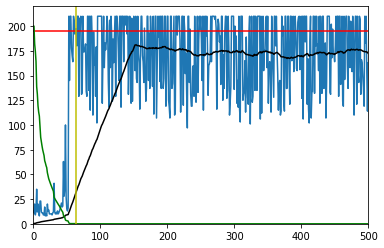

In [ ]:
#Plotting
rolling_average = np.convolve(rewards, np.ones(100)/100)

plt.plot(rewards)
plt.plot(rolling_average, color='black')
plt.axhline(y=195, color='r', linestyle='-') #Solved Line
#Scale Epsilon (0.001 - 1.0) to match reward (0 - 200) range
eps_graph = [200*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-')
#Plot the line where TESTING begins
plt.axvline(x=TRAIN_END, color='y', linestyle='-')
plt.xlim( (0,EPISODES) )
plt.ylim( (0,220) )
plt.show()